In [1]:
import pandas as pd
import requests
import logging

import os
# create folder if doesnt exists
current_directory = os.getcwd()

DATA_DIR = os.path.join(current_directory,"data")
MODEL_ARTIFACTS_DIR  = os.path.join(current_directory,"model_artifacts") 
DOWNLOAD_DIR = os.path.join(DATA_DIR,"downloads")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(DOWNLOAD_DIR):
    os.makedirs(DOWNLOAD_DIR)
    
if not os.path.exists(MODEL_ARTIFACTS_DIR):
    os.makedirs(MODEL_ARTIFACTS_DIR)
    
    
from pathlib import Path  # Import the Path module

# Convert the directory paths to Path objects
DOWNLOAD_DIR_PATH = Path(DOWNLOAD_DIR)  # Convert DOWNLOAD_DIR to a Path object
DATA_DIR_PATH = Path(DATA_DIR)          # Convert DATA_DIR to a Path object
MODEL_ARTIFACTS_DIR_PATH = Path(MODEL_ARTIFACTS_DIR)   

### Read data for the model

In [2]:
def read_data_and_drop_duplicates(input_file, reset_index=True):
    # Read the DataFrame from the Parquet file
    df = pd.read_csv(input_file)
    
    # Check for duplicate rows
    duplicates = df.duplicated()

    # Print the duplicate rows (if any)
    if duplicates.any():
        print("Duplicate rows found: ", len(df[duplicates]))
    else:
        print("No Duplicates")

    # Drop duplicate rows and keep the first occurrence
    df.drop_duplicates(keep='first', inplace=True)

    # Optionally, reset the index if needed
    if reset_index:
        df.reset_index(drop=True, inplace=True)
    print("Target column count::")
    print(df['Exited'].value_counts())
    
    return df

In [5]:
INPUT_FILE = DATA_DIR_PATH / f"Customer-Churn-Records.csv"
df = read_data_and_drop_duplicates(INPUT_FILE)
df.head(5)

No Duplicates

0    7962
1    2038
Name: Exited, dtype: int64


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [6]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df.drop(cols_to_drop,axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')

In [7]:
cat_columns = ['Geography', 'Gender', 'Tenure','NumOfProducts','HasCrCard',
               'IsActiveMember','Complain','Satisfaction Score','Card Type']
# Define the columns needed for one-hot encoding and Min-Max scaling
cat_columns_to_encode =  ['Gender', 'Geography', 'Card Type','Tenure','NumOfProducts','Satisfaction Score']


numerical_columns = ['CreditScore','Age','Balance','EstimatedSalary','Point Earned']

### EDA

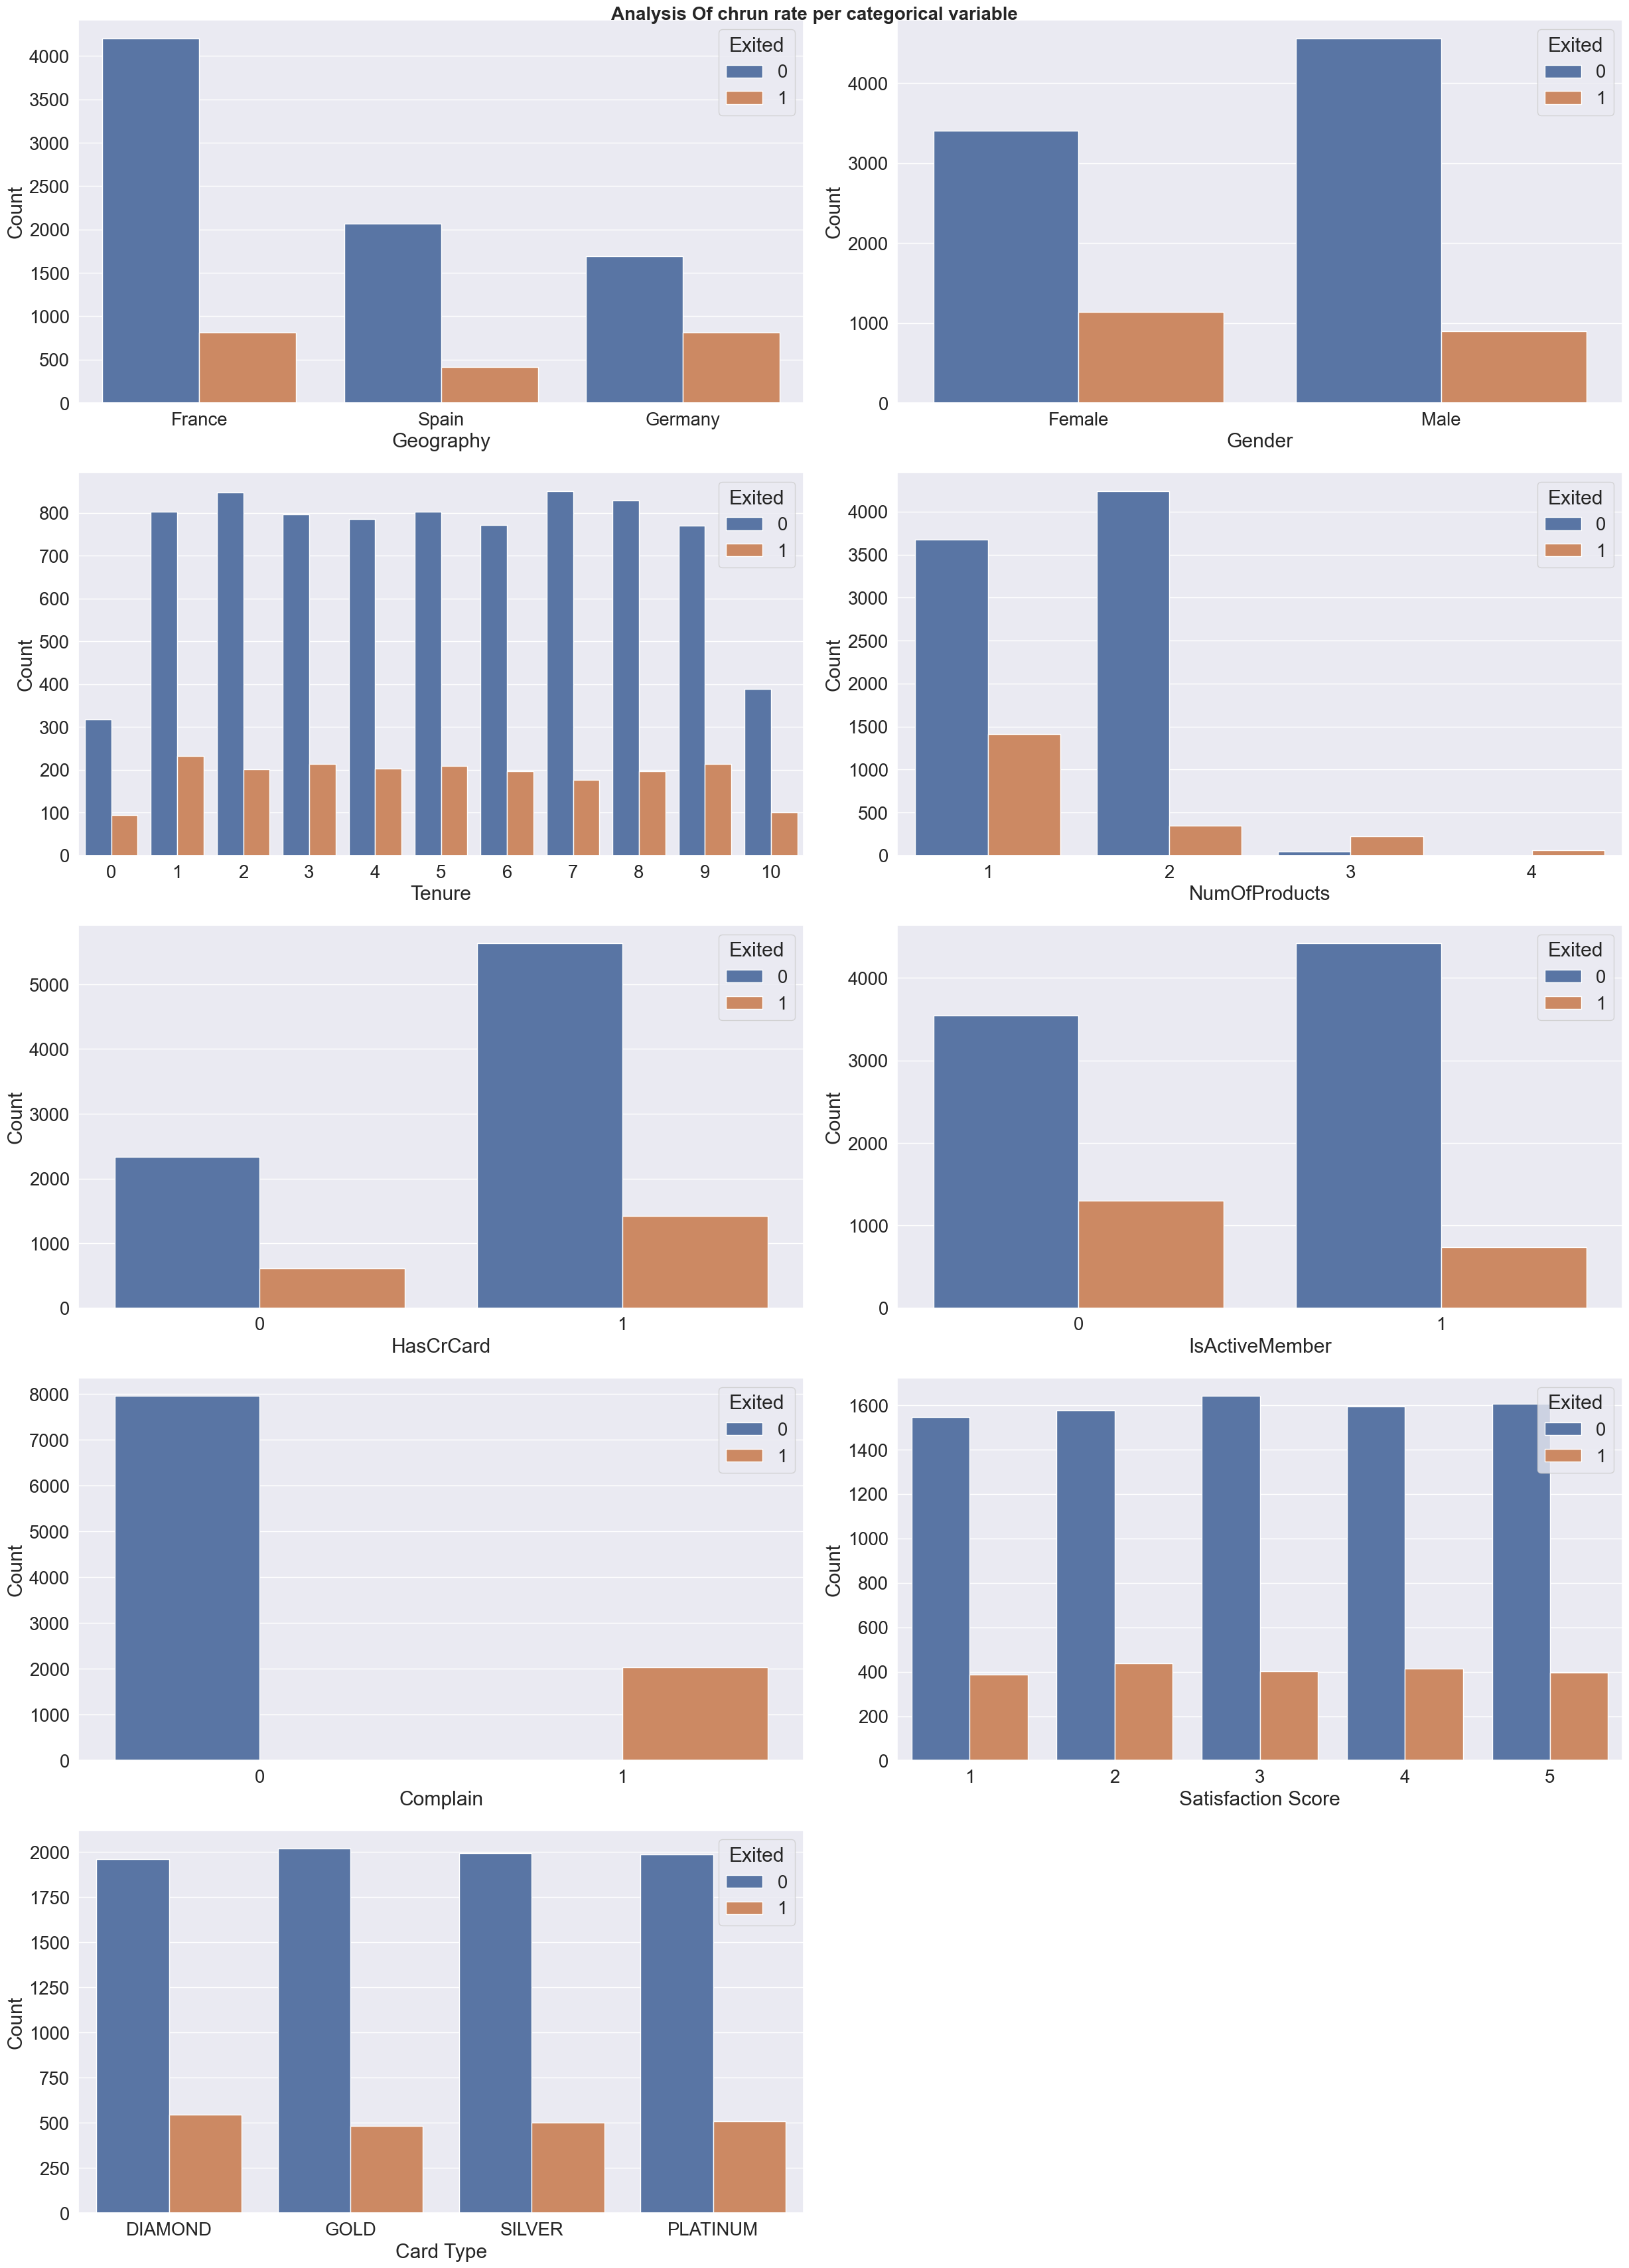

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda_cat_variable(cat_columns,fileName):
    
    # Create a figure outside the loop
    plt.figure(figsize=(25, 35))
    plt.suptitle("Analysis Of chrun rate per Categorical variable", fontweight="bold", fontsize=20)

    # Determine the number of rows and columns based on the number of categorical columns
    num_rows = len(cat_columns) // 2 + len(cat_columns) % 2
    num_cols = 2

    # Set the font size for all text elements in the plot
    sns.set(font_scale=1.8)

    for i in range(len(cat_columns)):
        plt.subplot(num_rows, num_cols, i + 1)
        #plt.gca().set_title(f'{cat_columns[i]}')
        sns.countplot(x=cat_columns[i], hue='Exited', data=df)

        #plt.xlabel(cat_columns[i])  # Use the default fontsize (scaled by sns.set())
        plt.ylabel('Count')  # Use the default fontsize (scaled by sns.set())

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()   
    
    
eda_cat_variable(cat_columns, os.path.join(DATA_DIR_PATH , "cat_eda.png"))

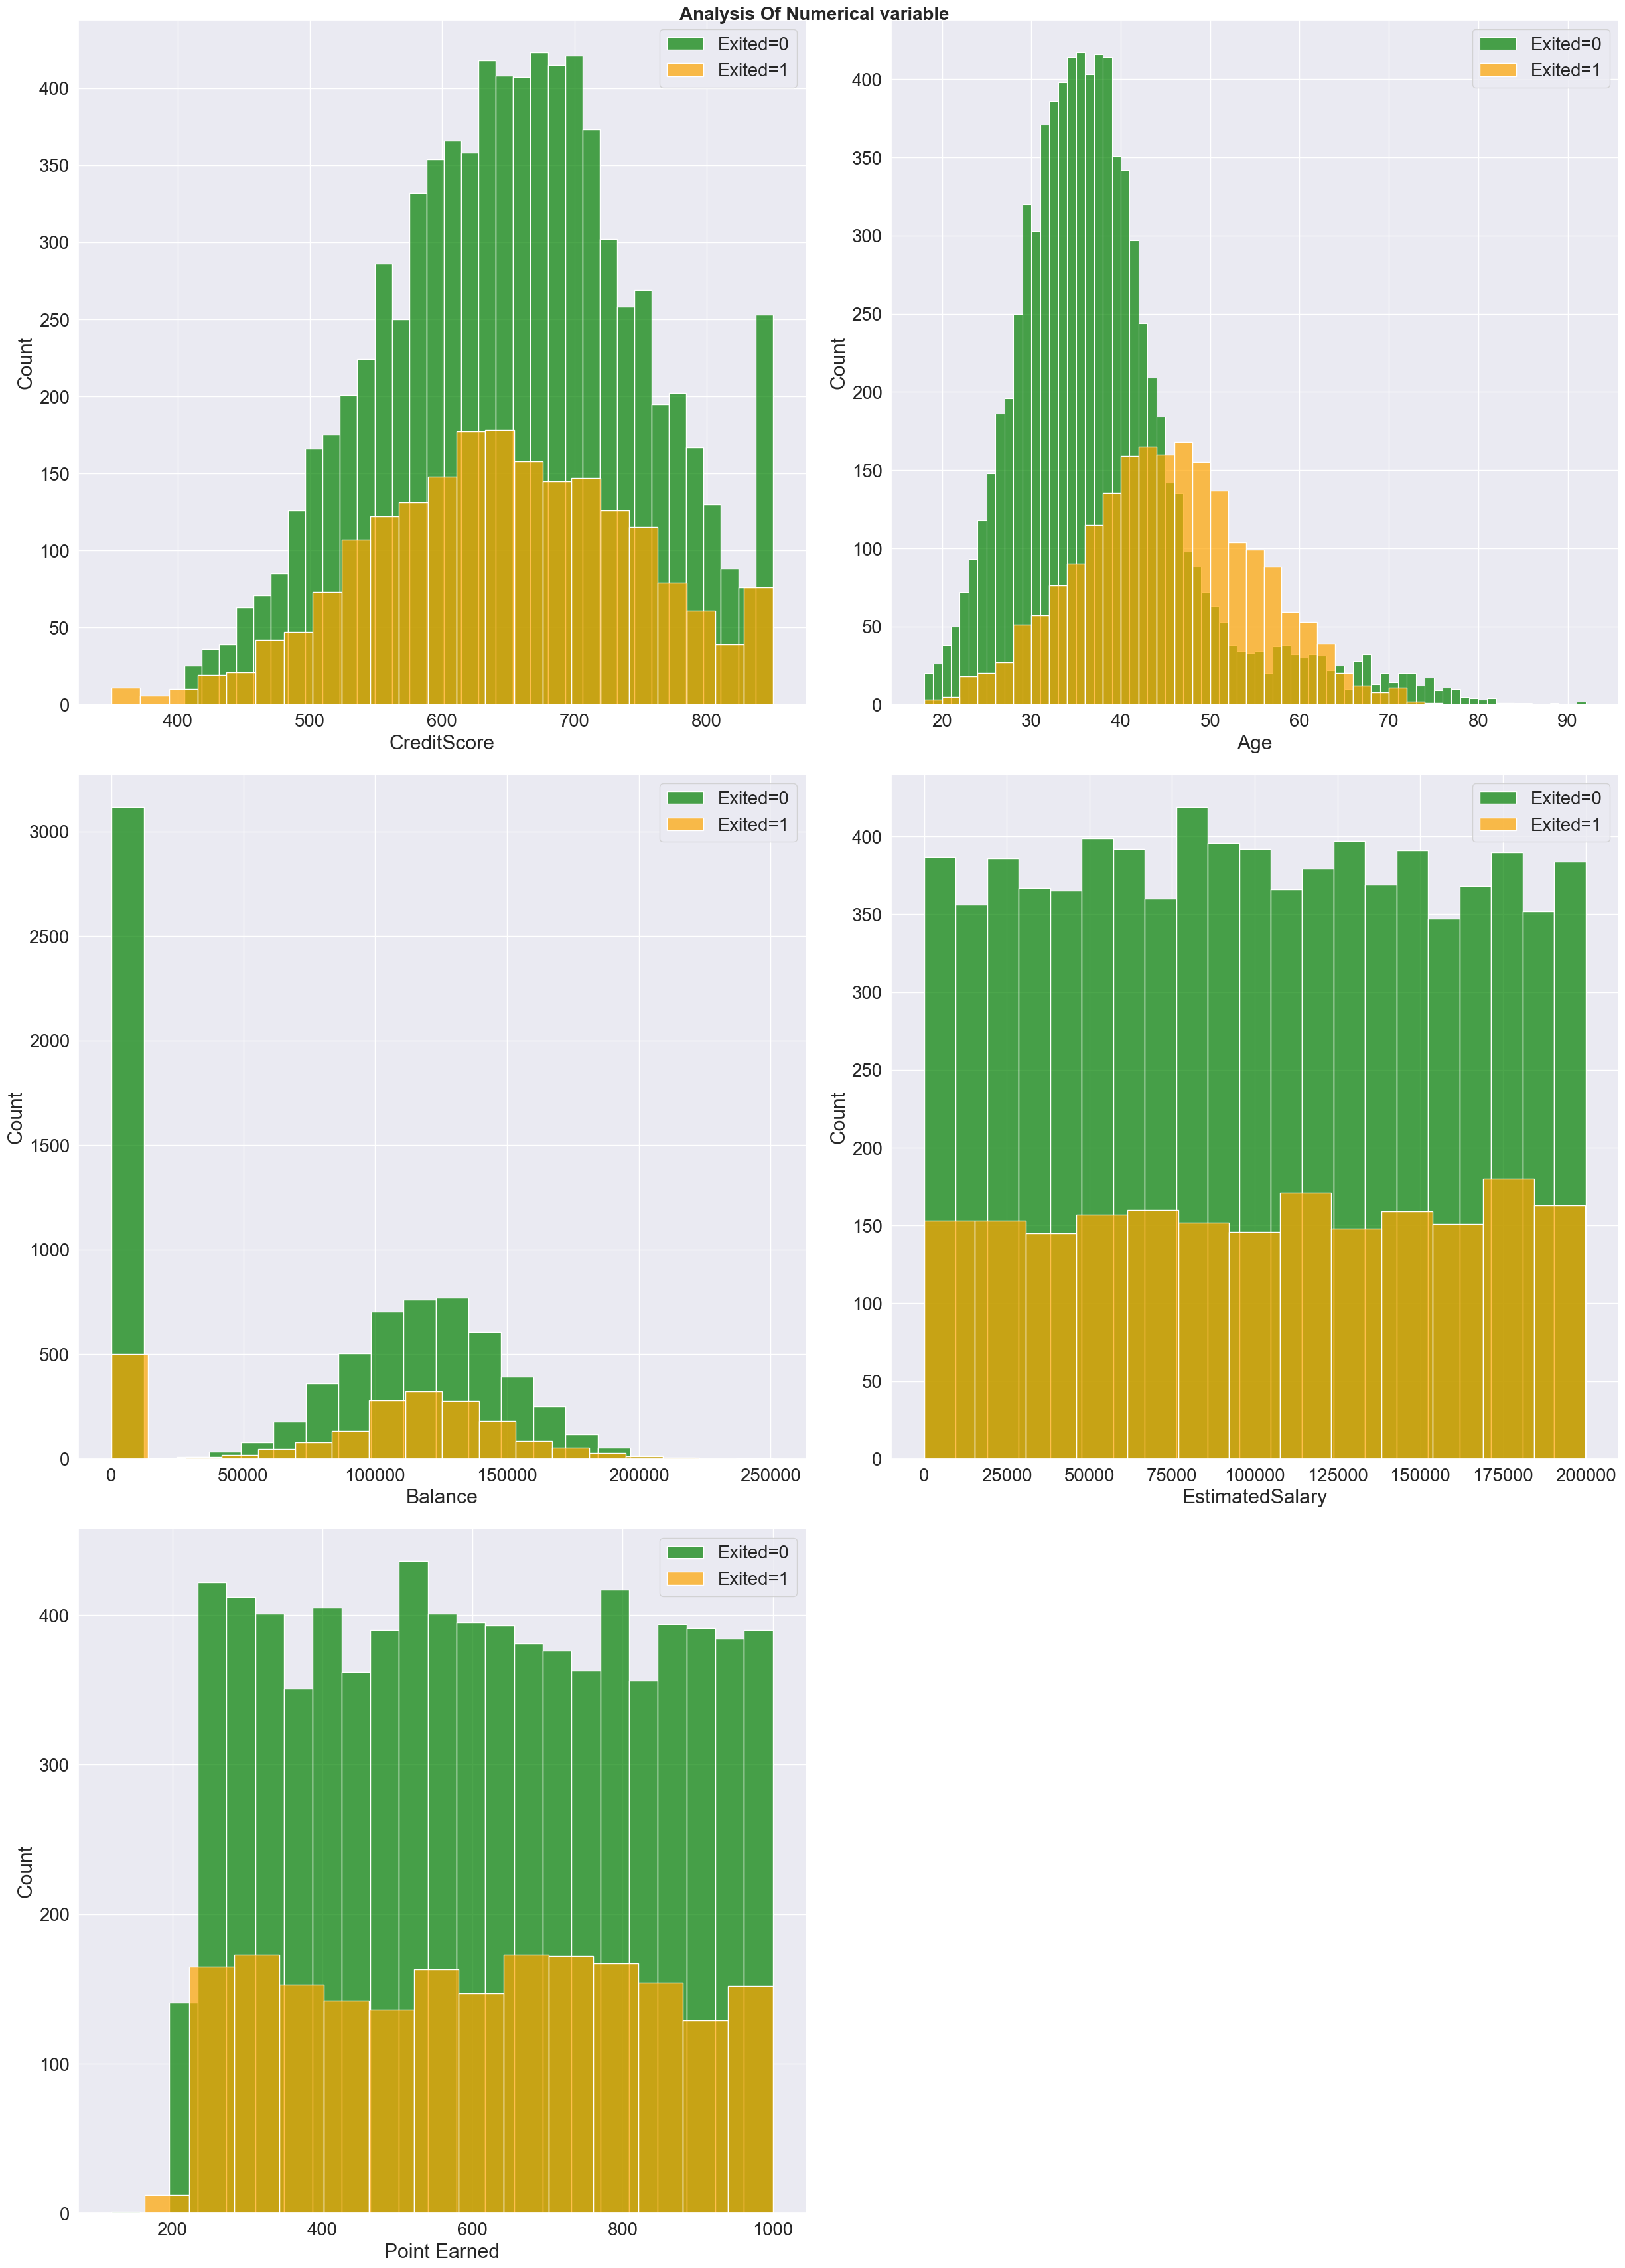

In [28]:
def eda_num_variable(numerical_columns,fileName):
    # Create a figure outside the loop
    plt.figure(figsize=(25, 35))
    plt.suptitle("Analysis Of chrun rate per Numerical variable", fontweight="bold", fontsize=20)

    # Determine the number of rows and columns based on the number of numerical columns
    num_rows = len(numerical_columns) // 2 + len(numerical_columns) % 2
    num_cols = 2

    # Set the font size for all text elements in the plot
    sns.set(font_scale=1.8)

    for i in range(len(numerical_columns)):
        plt.subplot(num_rows, num_cols, i + 1)

        # Plot the histogram for 'Exited' == 0
        sns.histplot(x=numerical_columns[i], data=df[df['Exited'] == 0], color='green', label='Exited=0', alpha=0.7)

        # Plot the histogram for 'Exited' == 1
        sns.histplot(x=numerical_columns[i], data=df[df['Exited'] == 1], color='orange', label='Exited=1', alpha=0.7)

        plt.xlabel(numerical_columns[i])  # Set the x-axis label
        plt.ylabel('Count')  # Use the default fontsize (scaled by sns.set())

        plt.legend()  # Add a legend to distinguish the two categories

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()


# Call the function with numerical_columns as argument
eda_num_variable(numerical_columns, os.path.join(DATA_DIR_PATH , "num_eda.png"))


### check correlation

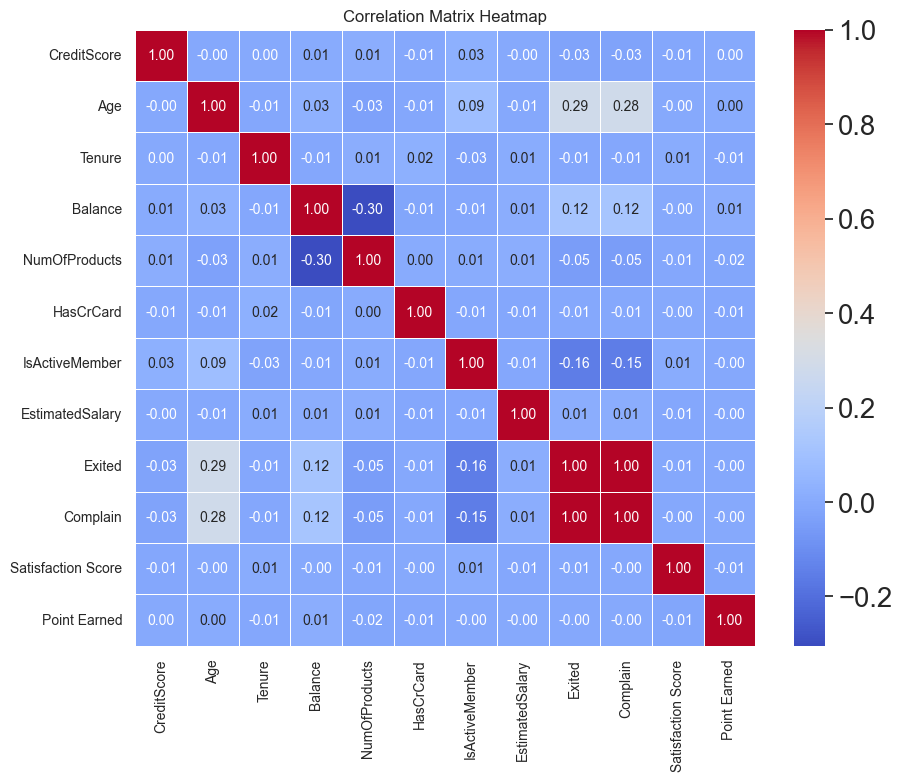

In [26]:
pd.set_option('display.max_columns', 25)

def plot_corr_matrix(encoded_df,fileName):
    correlation_matrix = encoded_df.corr(numeric_only=True)

    # Create the heatmap
    plt.figure(figsize=(10, 8))  # Adjust the size of the figure as per your preference
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
                linewidths=0.5 , annot_kws={"size": 10})
    plt.title("Correlation Matrix Heatmap", fontsize=12)

    plt.yticks(fontsize=10)  # Increase the font size of y-axis labels
    plt.xticks(fontsize=10)  # Increase the font size of x-axis labels

    plt.savefig(fileName)
    plt.show()
    
plot_corr_matrix(df,os.path.join(DATA_DIR_PATH , "correlation.png"))

### Split the data into training, validation and testing

In [11]:
import pandas as pd
from sklearn.model_selection import ShuffleSplit

def shuffle_split_unbalanced_df(df, target_column, test_size=0.2, validation_size=0.15, random_state=None):
    # Separate features (X) and target variable (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Create a ShuffleSplit cross-validator
    shuffle_split = ShuffleSplit(n_splits=1, test_size=test_size + validation_size, random_state=random_state)

    # Generate the shuffling splits
    for train_temp_index, test_index in shuffle_split.split(X):
        # Split data into training and temporary set (remaining data)
        X_train_temp, X_test = X.iloc[train_temp_index], X.iloc[test_index]
        y_train_temp, y_test = y.iloc[train_temp_index], y.iloc[test_index]

    # Calculate the percentage of validation set out of the temporary set
    validation_ratio = validation_size / (1 - test_size)

    # Create another ShuffleSplit cross-validator for the temporary set
    shuffle_split_temp = ShuffleSplit(n_splits=1, test_size=validation_ratio, random_state=random_state)

    # Generate the shuffling splits for the temporary set
    for train_index, validation_index in shuffle_split_temp.split(X_train_temp):
        # Split temporary set into training and validation sets
        X_train, X_validation = X_train_temp.iloc[train_index], X_train_temp.iloc[validation_index]
        y_train, y_validation = y_train_temp.iloc[train_index], y_train_temp.iloc[validation_index]

    return X_train, X_test, X_validation, y_train, y_test, y_validation


### Encode and scale

In [12]:
import joblib
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


def encode_scale_data(df, onehot_columns=None,scaling_columns=None, save_encoder=True):
    df_encoded = df.copy()
    
    # Reset the index to ensure unique indices before encoding
    df_encoded.reset_index(drop=True, inplace=True)
    
    # One-hot encode specified columns
    if onehot_columns is not None:
        for column in onehot_columns:
            encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
            encoded_column = encoder.fit_transform(df_encoded[[column]])
            encoded_column_df = pd.DataFrame(encoded_column, columns=encoder.get_feature_names_out([column]))
            df_encoded = pd.concat([df_encoded, encoded_column_df], axis=1)
            df_encoded.drop(column, axis=1, inplace=True)
            
            if save_encoder:
                joblib.dump(encoder, os.path.join(MODEL_ARTIFACTS_DIR, f'{column}_encoder.joblib'))
     

    # Perform Min-Max scaling on specified columns
    if scaling_columns is not None:
        scalers = {}
        for column in scaling_columns:
            scaler = MinMaxScaler()
            df_encoded[column] = scaler.fit_transform(df_encoded[[column]])

            if save_encoder:
                joblib.dump(scaler, os.path.join(MODEL_ARTIFACTS_DIR, f'{column}_scaler.joblib'))
            
            scalers[column] = scaler

    return df_encoded


In [13]:
## TO encode unseen data
def load_encoders(encoder_folder=MODEL_ARTIFACTS_DIR):
    encoder_files = os.listdir(encoder_folder)
    encoder_files = [file for file in encoder_files if file.endswith('.joblib')]
    
    encoders = {}
    for file in encoder_files:
        name, _ = os.path.splitext(file)
        encoder_path = os.path.join(encoder_folder, file)
        encoder_categories = joblib.load(encoder_path)
        encoder_name = name.rsplit('_', 1)[0]
        encoders[encoder_name] = encoder_categories

    return encoders

def apply_encoding_and_scaling(df, encoders,onehot_columns=None,scaling_columns=None):
    df_encoded = df.copy()
    # Reset the index to ensure unique indices before encoding
    df_encoded.reset_index(drop=True, inplace=True)

    # One-hot encode specified columns
    if onehot_columns is not None:
        for column in onehot_columns:
            encoder = encoders[column]
            encoded_data = encoder.transform(df_encoded[[column]])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
            df_encoded.drop(column, axis=1, inplace=True)
            df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
        
    # Perform Min-Max scaling on specified columns
    if scaling_columns is not None:
        for column in scaling_columns:
            scaler = encoders[column]
            df_encoded[column] = scaler.transform(df_encoded[[column]])

    return df_encoded
        

In [14]:
def get_train_test_validation_data(df):
    X_tr, X_te, X_val, y_train, y_test, y_validation = shuffle_split_unbalanced_df(df, target_column='Exited', 
                                                                                              test_size=0.2, validation_size=0.15, random_state=42)
    X_train = encode_scale_data(X_tr, onehot_columns=cat_columns_to_encode,
                                scaling_columns=numerical_columns, save_encoder=True)

    encoders = load_encoders()
    X_validation = apply_encoding_and_scaling(X_val,encoders,onehot_columns=cat_columns_to_encode, scaling_columns=numerical_columns)
    X_test = apply_encoding_and_scaling(X_te ,encoders,onehot_columns=cat_columns_to_encode,scaling_columns=numerical_columns)
    
     # Save the data to files
    train_data = pd.concat([X_train, y_train], axis=1)
    validation_data = pd.concat([X_validation, y_validation], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    train_data.to_csv(os.path.join(data_dir, training_data_filename), index=False)
    validation_data.to_csv(os.path.join(data_dir, validation_data_filename), index=False)
    test_data.to_csv(os.path.join(data_dir, testing_data_filename), index=False)
    
    return X_train, X_test, X_validation, y_train, y_test, y_validation
    
X_train, X_test, X_validation, y_train, y_test, y_validation = get_train_test_validation_data(df)

### Train baseline model

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def calculate_scores(actual, predictions,model):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    f1 = f1_score(actual, predictions)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})  # Change font size here
    plt.xlabel("Predicted Labels", fontsize=12)  # Change x-label font size
    plt.ylabel("True Labels", fontsize=12)  # Change y-label font size
    plt.title("Confusion Matrix", fontsize=13)  # Change title font size
    plt.xticks(fontsize=12)  # Change x tick labels font size
    plt.yticks(fontsize=12)  # Change y tick labels font size
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_ARTIFACTS_DIR , model+"_.png") )
    plt.show()
    
    return accuracy, precision, recall, f1



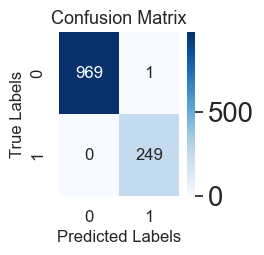

Logistic Regression Accuracy: 0.9991796554552912
Logistic Regression F1-Score: 0.9979959919839679
Logistic Regression precision: 0.996
Logistic Regression recall: 1.0


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def train_evaluate_LR(X_train, y_train, X_val, y_val,model):
    # Create a logistic regression model
    lr = LogisticRegression()

    # Train the model on the training data
    lr.fit(X_train, y_train)

    # Make predictions on the validation data
    val_predictions = lr.predict(X_val)

    # Calculate accuracy and F1-score on the validation data
    return calculate_scores(y_val, val_predictions,model)

# Assuming you have X_val and y_val as your validation data, call the function with your data
lr_accuracy, lr_precision, lr_recall, lr_f1 = train_evaluate_LR(X_train, y_train
                                                                ,X_validation, y_validation,'LR_confusionmatrix')

# Print the results
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression F1-Score:", lr_f1)
print("Logistic Regression precision:", lr_precision)
print("Logistic Regression recall:", lr_recall)

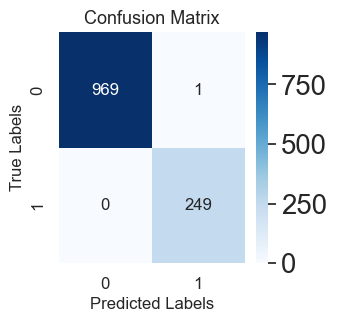

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Grid Search Accuracy: 0.9991796554552912
Grid Search F1-Score: 0.9979959919839679
Grid Search precision: 0.996
Grid Search recall: 1.0


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

def grid_search_RF(X_train, y_train, X_val, y_val):
    # Hyperparameter grid for Random Forest Classifier
    param_grid = {'n_estimators': [100, 200, 300,500], 
                  'max_depth': [5, 7, 10], 
                  'min_samples_split': [2, 5, 10]}

    # Create a RandomForestClassifier
    rf = RandomForestClassifier(class_weight='balanced')

    # Grid Search Cross Validation
    grid_search = GridSearchCV(rf, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Best hyperparameters
    best_params = grid_search.best_params_

    # Model evaluation using the best hyperparameters on the validation data
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)
    val_predictions = best_rf.predict(X_val) 
    
    gs_accuracy, gs_precision, gs_recall, gs_f1 = calculate_scores(y_val, val_predictions)
    
    # Save the best model and parameters to the specified directory
    model_path = os.path.join(MODEL_ARTIFACTS_DIR , 'best_model.joblib')
    params_path = os.path.join(MODEL_ARTIFACTS_DIR , 'best_params.joblib')
    joblib.dump(best_rf, model_path)
    joblib.dump(best_params, params_path)

    # Return the results
    return best_params, gs_accuracy, gs_precision, gs_recall, gs_f1

# Assuming you have X_val and y_val as your validation data, call the function with your data
best_params, gs_accuracy, gs_precision, gs_recall, gs_f1 = grid_search_RF(X_train, y_train, 
                                                                              X_validation, y_validation)

# Print the results
print("Best Hyperparameters:", best_params)
print("Grid Search Accuracy:", gs_accuracy)
print("Grid Search F1-Score:", gs_f1)
print("Grid Search precision:", gs_precision)
print("Grid Search recall:", gs_recall)

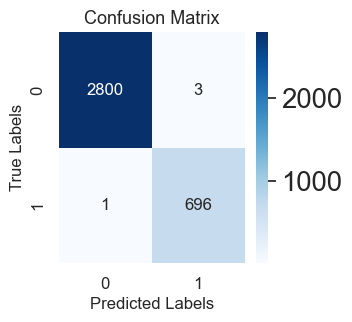

Test data RF Accuracy : 0.9988571428571429
Test data RF Precision: 0.9957081545064378
Test data RF Recall: 0.9985652797704447
Test data RF F1-score: 0.9971346704871059


In [20]:
# Function to load the model from the specified directory and make predictions
def load_and_predict(X_test):
    # Load the model from the directory
    model_path = os.path.join(MODEL_ARTIFACTS_DIR, 'best_model.joblib')
    best_model = joblib.load(model_path)
    
    # Make predictions using the loaded model
    predictions = best_model.predict(X_test)
    
    return predictions

# Assuming you have X_test as your test data and MODEL_ARTIFACTS_DIR as the directory where the model is stored
test_predictions = load_and_predict(X_test)


def evaluate_random_forest(X_test, y_test):
    predictions = load_and_predict(X_test)
    
    # Return the evaluation metrics
    return calculate_scores(y_test,predictions)

# Call the function with your data
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_random_forest(X_test, y_test)

# Print the results
print("Test data RF Accuracy :", rf_accuracy)
print("Test data RF Precision:", rf_precision)
print("Test data RF Recall:", rf_recall)
print("Test data RF F1-score:", rf_f1)
